# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

Use this block of code in case using with Colab

try:

  #%tensorflow_version only exists in Colab.
  
  %tensorflow_version 2.x
  
except Exception:
  pass

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [3]:
# function to pop target_variable/dependent_feature
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2

# function to normalize the datapoints
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

# function to plot regression between y_actual and y_predicted
def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()

# function to plot metrics
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [4]:
# Get the data from UCI dataset
URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URL)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [5]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [6]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [7]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Epoch 1/500
62/62 [==============================] - 1s 8ms/step - loss: 551.2770 - y1_output_loss: 267.8249 - y2_output_loss: 283.4521 - y1_output_root_mean_squared_error: 15.6609 - y2_output_root_mean_squared_error: 16.0969 - val_loss: 42.8727 - val_y1_output_loss: 18.5630 - val_y2_output_loss: 24.3098 - val_y1_output_root_mean_squared_error: 4.3085 - val_y2_output_root_mean_squared_error: 4.9305
Epoch 2/500
62/62 [==============================] - 0s 1ms/step - loss: 32.7513 - y1_output_loss: 12.9849 - y2_output_loss: 19.7664 - y1_output_root_mean_squared_error: 3.5946 - y2_output_root_mean_squared_error: 4.4343 - val_loss: 129.6100 - val_y1_output_loss: 34.2465 - val_y2_output_loss: 95.3636 - val_y1_output_root_mean_squared_error: 5.8520 - val_y2_output_root_mean_squared_error: 9.7654
Epoch 3/500
62/62 [==============================] - 0s 1ms/step - loss: 35.1547 - y1_output_loss: 11.5326 - y2_output_loss: 23.6221 - y1_output_root_mean_squared_error: 3.3792 - y2_output_root_mean_s

Epoch 22/500
62/62 [==============================] - 0s 1ms/step - loss: 17.6909 - y1_output_loss: 6.8428 - y2_output_loss: 10.8481 - y1_output_root_mean_squared_error: 2.6053 - y2_output_root_mean_squared_error: 3.2702 - val_loss: 24.9530 - val_y1_output_loss: 8.3543 - val_y2_output_loss: 16.5987 - val_y1_output_root_mean_squared_error: 2.8904 - val_y2_output_root_mean_squared_error: 4.0741
Epoch 23/500
62/62 [==============================] - 0s 1ms/step - loss: 14.6643 - y1_output_loss: 6.3072 - y2_output_loss: 8.3571 - y1_output_root_mean_squared_error: 2.5080 - y2_output_root_mean_squared_error: 2.8806 - val_loss: 25.2212 - val_y1_output_loss: 10.1300 - val_y2_output_loss: 15.0912 - val_y1_output_root_mean_squared_error: 3.1828 - val_y2_output_root_mean_squared_error: 3.8847
Epoch 24/500
62/62 [==============================] - 0s 1ms/step - loss: 19.9909 - y1_output_loss: 7.5062 - y2_output_loss: 12.4847 - y1_output_root_mean_squared_error: 2.7358 - y2_output_root_mean_squared_e

Epoch 43/500
62/62 [==============================] - 0s 1ms/step - loss: 8.1547 - y1_output_loss: 3.0935 - y2_output_loss: 5.0612 - y1_output_root_mean_squared_error: 1.7547 - y2_output_root_mean_squared_error: 2.2463 - val_loss: 8.7178 - val_y1_output_loss: 3.4336 - val_y2_output_loss: 5.2842 - val_y1_output_root_mean_squared_error: 1.8530 - val_y2_output_root_mean_squared_error: 2.2987
Epoch 44/500
62/62 [==============================] - 0s 1ms/step - loss: 8.1354 - y1_output_loss: 3.0944 - y2_output_loss: 5.0410 - y1_output_root_mean_squared_error: 1.7509 - y2_output_root_mean_squared_error: 2.2341 - val_loss: 8.1256 - val_y1_output_loss: 2.8513 - val_y2_output_loss: 5.2743 - val_y1_output_root_mean_squared_error: 1.6886 - val_y2_output_root_mean_squared_error: 2.2966
Epoch 45/500
62/62 [==============================] - 0s 1ms/step - loss: 7.5021 - y1_output_loss: 2.4851 - y2_output_loss: 5.0170 - y1_output_root_mean_squared_error: 1.5723 - y2_output_root_mean_squared_error: 2.23

Epoch 64/500
62/62 [==============================] - 0s 1ms/step - loss: 7.4878 - y1_output_loss: 2.0239 - y2_output_loss: 5.4639 - y1_output_root_mean_squared_error: 1.4173 - y2_output_root_mean_squared_error: 2.3244 - val_loss: 6.2239 - val_y1_output_loss: 1.6645 - val_y2_output_loss: 4.5594 - val_y1_output_root_mean_squared_error: 1.2902 - val_y2_output_root_mean_squared_error: 2.1353
Epoch 65/500
62/62 [==============================] - 0s 2ms/step - loss: 5.3210 - y1_output_loss: 1.5460 - y2_output_loss: 3.7750 - y1_output_root_mean_squared_error: 1.2395 - y2_output_root_mean_squared_error: 1.9390 - val_loss: 6.0205 - val_y1_output_loss: 1.8099 - val_y2_output_loss: 4.2106 - val_y1_output_root_mean_squared_error: 1.3453 - val_y2_output_root_mean_squared_error: 2.0520
Epoch 66/500
62/62 [==============================] - 0s 2ms/step - loss: 5.2446 - y1_output_loss: 1.3591 - y2_output_loss: 3.8855 - y1_output_root_mean_squared_error: 1.1584 - y2_output_root_mean_squared_error: 1.96

Epoch 85/500
62/62 [==============================] - 0s 1ms/step - loss: 3.9267 - y1_output_loss: 1.0413 - y2_output_loss: 2.8855 - y1_output_root_mean_squared_error: 1.0085 - y2_output_root_mean_squared_error: 1.6724 - val_loss: 10.7212 - val_y1_output_loss: 2.9428 - val_y2_output_loss: 7.7784 - val_y1_output_root_mean_squared_error: 1.7155 - val_y2_output_root_mean_squared_error: 2.7890
Epoch 86/500
62/62 [==============================] - 0s 1ms/step - loss: 3.0968 - y1_output_loss: 0.8800 - y2_output_loss: 2.2168 - y1_output_root_mean_squared_error: 0.9328 - y2_output_root_mean_squared_error: 1.4860 - val_loss: 15.2233 - val_y1_output_loss: 3.2600 - val_y2_output_loss: 11.9633 - val_y1_output_root_mean_squared_error: 1.8055 - val_y2_output_root_mean_squared_error: 3.4588
Epoch 87/500
62/62 [==============================] - 0s 1ms/step - loss: 3.3646 - y1_output_loss: 0.8749 - y2_output_loss: 2.4897 - y1_output_root_mean_squared_error: 0.9227 - y2_output_root_mean_squared_error: 1

Epoch 106/500
62/62 [==============================] - 0s 1ms/step - loss: 9.4186 - y1_output_loss: 2.9570 - y2_output_loss: 6.4616 - y1_output_root_mean_squared_error: 1.6419 - y2_output_root_mean_squared_error: 2.4735 - val_loss: 8.1580 - val_y1_output_loss: 1.6256 - val_y2_output_loss: 6.5325 - val_y1_output_root_mean_squared_error: 1.2750 - val_y2_output_root_mean_squared_error: 2.5559
Epoch 107/500
62/62 [==============================] - 0s 1ms/step - loss: 2.8518 - y1_output_loss: 0.6199 - y2_output_loss: 2.2319 - y1_output_root_mean_squared_error: 0.7848 - y2_output_root_mean_squared_error: 1.4905 - val_loss: 2.8342 - val_y1_output_loss: 0.5368 - val_y2_output_loss: 2.2975 - val_y1_output_root_mean_squared_error: 0.7326 - val_y2_output_root_mean_squared_error: 1.5157
Epoch 108/500
62/62 [==============================] - 0s 1ms/step - loss: 3.0689 - y1_output_loss: 0.6814 - y2_output_loss: 2.3874 - y1_output_root_mean_squared_error: 0.8153 - y2_output_root_mean_squared_error: 1

Epoch 127/500
62/62 [==============================] - 0s 1ms/step - loss: 3.0376 - y1_output_loss: 0.6276 - y2_output_loss: 2.4099 - y1_output_root_mean_squared_error: 0.7872 - y2_output_root_mean_squared_error: 1.5372 - val_loss: 2.3339 - val_y1_output_loss: 0.5169 - val_y2_output_loss: 1.8170 - val_y1_output_root_mean_squared_error: 0.7190 - val_y2_output_root_mean_squared_error: 1.3480
Epoch 128/500
62/62 [==============================] - 0s 1ms/step - loss: 3.2295 - y1_output_loss: 0.7702 - y2_output_loss: 2.4593 - y1_output_root_mean_squared_error: 0.8630 - y2_output_root_mean_squared_error: 1.5495 - val_loss: 2.9550 - val_y1_output_loss: 0.3861 - val_y2_output_loss: 2.5688 - val_y1_output_root_mean_squared_error: 0.6214 - val_y2_output_root_mean_squared_error: 1.6028
Epoch 129/500
62/62 [==============================] - 0s 1ms/step - loss: 1.5506 - y1_output_loss: 0.3014 - y2_output_loss: 1.2492 - y1_output_root_mean_squared_error: 0.5464 - y2_output_root_mean_squared_error: 1

Epoch 148/500
62/62 [==============================] - 0s 1ms/step - loss: 2.2137 - y1_output_loss: 0.4897 - y2_output_loss: 1.7240 - y1_output_root_mean_squared_error: 0.6925 - y2_output_root_mean_squared_error: 1.3045 - val_loss: 2.2223 - val_y1_output_loss: 0.4384 - val_y2_output_loss: 1.7839 - val_y1_output_root_mean_squared_error: 0.6621 - val_y2_output_root_mean_squared_error: 1.3356
Epoch 149/500
62/62 [==============================] - 0s 1ms/step - loss: 1.9317 - y1_output_loss: 0.4100 - y2_output_loss: 1.5218 - y1_output_root_mean_squared_error: 0.6172 - y2_output_root_mean_squared_error: 1.1919 - val_loss: 2.5704 - val_y1_output_loss: 0.4205 - val_y2_output_loss: 2.1499 - val_y1_output_root_mean_squared_error: 0.6485 - val_y2_output_root_mean_squared_error: 1.4662
Epoch 150/500
62/62 [==============================] - 0s 1ms/step - loss: 1.5964 - y1_output_loss: 0.3609 - y2_output_loss: 1.2355 - y1_output_root_mean_squared_error: 0.6005 - y2_output_root_mean_squared_error: 1

Epoch 169/500
62/62 [==============================] - 0s 1ms/step - loss: 1.2909 - y1_output_loss: 0.2321 - y2_output_loss: 1.0588 - y1_output_root_mean_squared_error: 0.4811 - y2_output_root_mean_squared_error: 1.0271 - val_loss: 1.9258 - val_y1_output_loss: 0.3881 - val_y2_output_loss: 1.5377 - val_y1_output_root_mean_squared_error: 0.6230 - val_y2_output_root_mean_squared_error: 1.2400
Epoch 170/500
62/62 [==============================] - 0s 1ms/step - loss: 1.8047 - y1_output_loss: 0.4050 - y2_output_loss: 1.3997 - y1_output_root_mean_squared_error: 0.6346 - y2_output_root_mean_squared_error: 1.1737 - val_loss: 2.1006 - val_y1_output_loss: 0.4740 - val_y2_output_loss: 1.6266 - val_y1_output_root_mean_squared_error: 0.6885 - val_y2_output_root_mean_squared_error: 1.2754
Epoch 171/500
62/62 [==============================] - 0s 1ms/step - loss: 1.4302 - y1_output_loss: 0.3374 - y2_output_loss: 1.0929 - y1_output_root_mean_squared_error: 0.5763 - y2_output_root_mean_squared_error: 1

Epoch 190/500
62/62 [==============================] - 0s 1ms/step - loss: 1.4969 - y1_output_loss: 0.3532 - y2_output_loss: 1.1438 - y1_output_root_mean_squared_error: 0.5917 - y2_output_root_mean_squared_error: 1.0593 - val_loss: 2.0826 - val_y1_output_loss: 0.3222 - val_y2_output_loss: 1.7604 - val_y1_output_root_mean_squared_error: 0.5676 - val_y2_output_root_mean_squared_error: 1.3268
Epoch 191/500
62/62 [==============================] - 0s 1ms/step - loss: 1.7033 - y1_output_loss: 0.3814 - y2_output_loss: 1.3219 - y1_output_root_mean_squared_error: 0.6143 - y2_output_root_mean_squared_error: 1.1469 - val_loss: 2.7971 - val_y1_output_loss: 0.4526 - val_y2_output_loss: 2.3444 - val_y1_output_root_mean_squared_error: 0.6728 - val_y2_output_root_mean_squared_error: 1.5312
Epoch 192/500
62/62 [==============================] - 0s 1ms/step - loss: 1.8880 - y1_output_loss: 0.4113 - y2_output_loss: 1.4767 - y1_output_root_mean_squared_error: 0.6314 - y2_output_root_mean_squared_error: 1

Epoch 211/500
62/62 [==============================] - 0s 1ms/step - loss: 1.2333 - y1_output_loss: 0.2287 - y2_output_loss: 1.0046 - y1_output_root_mean_squared_error: 0.4773 - y2_output_root_mean_squared_error: 0.9965 - val_loss: 3.5069 - val_y1_output_loss: 0.4135 - val_y2_output_loss: 3.0933 - val_y1_output_root_mean_squared_error: 0.6430 - val_y2_output_root_mean_squared_error: 1.7588
Epoch 212/500
62/62 [==============================] - 0s 2ms/step - loss: 1.5914 - y1_output_loss: 0.2745 - y2_output_loss: 1.3169 - y1_output_root_mean_squared_error: 0.5214 - y2_output_root_mean_squared_error: 1.1327 - val_loss: 1.9267 - val_y1_output_loss: 0.3540 - val_y2_output_loss: 1.5727 - val_y1_output_root_mean_squared_error: 0.5949 - val_y2_output_root_mean_squared_error: 1.2541
Epoch 213/500
62/62 [==============================] - 0s 2ms/step - loss: 1.4334 - y1_output_loss: 0.2902 - y2_output_loss: 1.1432 - y1_output_root_mean_squared_error: 0.5363 - y2_output_root_mean_squared_error: 1

Epoch 232/500
62/62 [==============================] - 0s 1ms/step - loss: 1.1183 - y1_output_loss: 0.2384 - y2_output_loss: 0.8799 - y1_output_root_mean_squared_error: 0.4857 - y2_output_root_mean_squared_error: 0.9333 - val_loss: 2.4545 - val_y1_output_loss: 0.4130 - val_y2_output_loss: 2.0415 - val_y1_output_root_mean_squared_error: 0.6426 - val_y2_output_root_mean_squared_error: 1.4288
Epoch 233/500
62/62 [==============================] - 0s 1ms/step - loss: 1.7661 - y1_output_loss: 0.4418 - y2_output_loss: 1.3243 - y1_output_root_mean_squared_error: 0.6624 - y2_output_root_mean_squared_error: 1.1469 - val_loss: 5.5720 - val_y1_output_loss: 0.7397 - val_y2_output_loss: 4.8323 - val_y1_output_root_mean_squared_error: 0.8601 - val_y2_output_root_mean_squared_error: 2.1982
Epoch 234/500
62/62 [==============================] - 0s 1ms/step - loss: 1.6422 - y1_output_loss: 0.3425 - y2_output_loss: 1.2997 - y1_output_root_mean_squared_error: 0.5829 - y2_output_root_mean_squared_error: 1

Epoch 253/500
62/62 [==============================] - 0s 1ms/step - loss: 0.8227 - y1_output_loss: 0.1774 - y2_output_loss: 0.6453 - y1_output_root_mean_squared_error: 0.4185 - y2_output_root_mean_squared_error: 0.7990 - val_loss: 1.9361 - val_y1_output_loss: 0.2231 - val_y2_output_loss: 1.7130 - val_y1_output_root_mean_squared_error: 0.4723 - val_y2_output_root_mean_squared_error: 1.3088
Epoch 254/500
62/62 [==============================] - 0s 1ms/step - loss: 1.1931 - y1_output_loss: 0.2254 - y2_output_loss: 0.9676 - y1_output_root_mean_squared_error: 0.4727 - y2_output_root_mean_squared_error: 0.9780 - val_loss: 1.4503 - val_y1_output_loss: 0.2090 - val_y2_output_loss: 1.2413 - val_y1_output_root_mean_squared_error: 0.4571 - val_y2_output_root_mean_squared_error: 1.1141
Epoch 255/500
62/62 [==============================] - 0s 1ms/step - loss: 0.9360 - y1_output_loss: 0.2232 - y2_output_loss: 0.7129 - y1_output_root_mean_squared_error: 0.4710 - y2_output_root_mean_squared_error: 0

Epoch 274/500
62/62 [==============================] - 0s 1ms/step - loss: 1.2520 - y1_output_loss: 0.2659 - y2_output_loss: 0.9861 - y1_output_root_mean_squared_error: 0.5139 - y2_output_root_mean_squared_error: 0.9890 - val_loss: 2.5033 - val_y1_output_loss: 0.3249 - val_y2_output_loss: 2.1784 - val_y1_output_root_mean_squared_error: 0.5700 - val_y2_output_root_mean_squared_error: 1.4759
Epoch 275/500
62/62 [==============================] - 0s 1ms/step - loss: 1.1734 - y1_output_loss: 0.2156 - y2_output_loss: 0.9578 - y1_output_root_mean_squared_error: 0.4630 - y2_output_root_mean_squared_error: 0.9768 - val_loss: 1.5774 - val_y1_output_loss: 0.3721 - val_y2_output_loss: 1.2053 - val_y1_output_root_mean_squared_error: 0.6100 - val_y2_output_root_mean_squared_error: 1.0979
Epoch 276/500
62/62 [==============================] - 0s 1ms/step - loss: 0.7669 - y1_output_loss: 0.1618 - y2_output_loss: 0.6051 - y1_output_root_mean_squared_error: 0.3993 - y2_output_root_mean_squared_error: 0

Epoch 295/500
62/62 [==============================] - 0s 1ms/step - loss: 0.8280 - y1_output_loss: 0.1726 - y2_output_loss: 0.6554 - y1_output_root_mean_squared_error: 0.4152 - y2_output_root_mean_squared_error: 0.8064 - val_loss: 1.5748 - val_y1_output_loss: 0.2619 - val_y2_output_loss: 1.3129 - val_y1_output_root_mean_squared_error: 0.5118 - val_y2_output_root_mean_squared_error: 1.1458
Epoch 296/500
62/62 [==============================] - 0s 2ms/step - loss: 0.7859 - y1_output_loss: 0.1782 - y2_output_loss: 0.6077 - y1_output_root_mean_squared_error: 0.4219 - y2_output_root_mean_squared_error: 0.7777 - val_loss: 1.7061 - val_y1_output_loss: 0.2559 - val_y2_output_loss: 1.4503 - val_y1_output_root_mean_squared_error: 0.5058 - val_y2_output_root_mean_squared_error: 1.2043
Epoch 297/500
62/62 [==============================] - 0s 2ms/step - loss: 0.7134 - y1_output_loss: 0.1566 - y2_output_loss: 0.5568 - y1_output_root_mean_squared_error: 0.3950 - y2_output_root_mean_squared_error: 0

Epoch 316/500
62/62 [==============================] - 0s 1ms/step - loss: 0.8458 - y1_output_loss: 0.2090 - y2_output_loss: 0.6367 - y1_output_root_mean_squared_error: 0.4504 - y2_output_root_mean_squared_error: 0.7897 - val_loss: 1.2610 - val_y1_output_loss: 0.2621 - val_y2_output_loss: 0.9990 - val_y1_output_root_mean_squared_error: 0.5119 - val_y2_output_root_mean_squared_error: 0.9995
Epoch 317/500
62/62 [==============================] - 0s 1ms/step - loss: 0.6490 - y1_output_loss: 0.1648 - y2_output_loss: 0.4841 - y1_output_root_mean_squared_error: 0.4052 - y2_output_root_mean_squared_error: 0.6892 - val_loss: 2.1632 - val_y1_output_loss: 0.2813 - val_y2_output_loss: 1.8819 - val_y1_output_root_mean_squared_error: 0.5304 - val_y2_output_root_mean_squared_error: 1.3718
Epoch 318/500
62/62 [==============================] - 0s 1ms/step - loss: 1.1336 - y1_output_loss: 0.2207 - y2_output_loss: 0.9128 - y1_output_root_mean_squared_error: 0.4683 - y2_output_root_mean_squared_error: 0

Epoch 337/500
62/62 [==============================] - 0s 1ms/step - loss: 0.6019 - y1_output_loss: 0.1753 - y2_output_loss: 0.4266 - y1_output_root_mean_squared_error: 0.4172 - y2_output_root_mean_squared_error: 0.6513 - val_loss: 1.7636 - val_y1_output_loss: 0.2659 - val_y2_output_loss: 1.4976 - val_y1_output_root_mean_squared_error: 0.5157 - val_y2_output_root_mean_squared_error: 1.2238
Epoch 338/500
62/62 [==============================] - 0s 1ms/step - loss: 0.5323 - y1_output_loss: 0.1223 - y2_output_loss: 0.4100 - y1_output_root_mean_squared_error: 0.3489 - y2_output_root_mean_squared_error: 0.6371 - val_loss: 2.0841 - val_y1_output_loss: 0.3476 - val_y2_output_loss: 1.7365 - val_y1_output_root_mean_squared_error: 0.5896 - val_y2_output_root_mean_squared_error: 1.3178
Epoch 339/500
62/62 [==============================] - 0s 1ms/step - loss: 1.2468 - y1_output_loss: 0.2790 - y2_output_loss: 0.9678 - y1_output_root_mean_squared_error: 0.5220 - y2_output_root_mean_squared_error: 0

Epoch 358/500
62/62 [==============================] - 0s 1ms/step - loss: 0.5666 - y1_output_loss: 0.1274 - y2_output_loss: 0.4392 - y1_output_root_mean_squared_error: 0.3548 - y2_output_root_mean_squared_error: 0.6589 - val_loss: 4.4344 - val_y1_output_loss: 0.3833 - val_y2_output_loss: 4.0511 - val_y1_output_root_mean_squared_error: 0.6191 - val_y2_output_root_mean_squared_error: 2.0127
Epoch 359/500
62/62 [==============================] - 0s 1ms/step - loss: 0.8369 - y1_output_loss: 0.1259 - y2_output_loss: 0.7110 - y1_output_root_mean_squared_error: 0.3543 - y2_output_root_mean_squared_error: 0.8275 - val_loss: 1.0991 - val_y1_output_loss: 0.2003 - val_y2_output_loss: 0.8988 - val_y1_output_root_mean_squared_error: 0.4475 - val_y2_output_root_mean_squared_error: 0.9481
Epoch 360/500
62/62 [==============================] - 0s 1ms/step - loss: 0.5321 - y1_output_loss: 0.1364 - y2_output_loss: 0.3957 - y1_output_root_mean_squared_error: 0.3686 - y2_output_root_mean_squared_error: 0

Epoch 379/500
62/62 [==============================] - 0s 1ms/step - loss: 0.5970 - y1_output_loss: 0.1345 - y2_output_loss: 0.4625 - y1_output_root_mean_squared_error: 0.3658 - y2_output_root_mean_squared_error: 0.6768 - val_loss: 1.1625 - val_y1_output_loss: 0.2095 - val_y2_output_loss: 0.9530 - val_y1_output_root_mean_squared_error: 0.4577 - val_y2_output_root_mean_squared_error: 0.9762
Epoch 380/500
62/62 [==============================] - 0s 1ms/step - loss: 0.5562 - y1_output_loss: 0.1267 - y2_output_loss: 0.4295 - y1_output_root_mean_squared_error: 0.3529 - y2_output_root_mean_squared_error: 0.6513 - val_loss: 1.2235 - val_y1_output_loss: 0.2341 - val_y2_output_loss: 0.9894 - val_y1_output_root_mean_squared_error: 0.4838 - val_y2_output_root_mean_squared_error: 0.9947
Epoch 381/500
62/62 [==============================] - 0s 1ms/step - loss: 0.8982 - y1_output_loss: 0.2148 - y2_output_loss: 0.6834 - y1_output_root_mean_squared_error: 0.4632 - y2_output_root_mean_squared_error: 0

Epoch 400/500
62/62 [==============================] - 0s 1ms/step - loss: 0.5813 - y1_output_loss: 0.1627 - y2_output_loss: 0.4185 - y1_output_root_mean_squared_error: 0.4019 - y2_output_root_mean_squared_error: 0.6456 - val_loss: 2.4037 - val_y1_output_loss: 0.6135 - val_y2_output_loss: 1.7903 - val_y1_output_root_mean_squared_error: 0.7832 - val_y2_output_root_mean_squared_error: 1.3380
Epoch 401/500
62/62 [==============================] - 0s 1ms/step - loss: 0.5882 - y1_output_loss: 0.1517 - y2_output_loss: 0.4365 - y1_output_root_mean_squared_error: 0.3829 - y2_output_root_mean_squared_error: 0.6538 - val_loss: 1.1683 - val_y1_output_loss: 0.2541 - val_y2_output_loss: 0.9142 - val_y1_output_root_mean_squared_error: 0.5041 - val_y2_output_root_mean_squared_error: 0.9561
Epoch 402/500
62/62 [==============================] - 0s 1ms/step - loss: 0.5843 - y1_output_loss: 0.1181 - y2_output_loss: 0.4663 - y1_output_root_mean_squared_error: 0.3430 - y2_output_root_mean_squared_error: 0

Epoch 421/500
62/62 [==============================] - 0s 1ms/step - loss: 0.5333 - y1_output_loss: 0.1732 - y2_output_loss: 0.3600 - y1_output_root_mean_squared_error: 0.4142 - y2_output_root_mean_squared_error: 0.5915 - val_loss: 1.3750 - val_y1_output_loss: 0.3939 - val_y2_output_loss: 0.9811 - val_y1_output_root_mean_squared_error: 0.6276 - val_y2_output_root_mean_squared_error: 0.9905
Epoch 422/500
62/62 [==============================] - 0s 1ms/step - loss: 0.7904 - y1_output_loss: 0.1540 - y2_output_loss: 0.6364 - y1_output_root_mean_squared_error: 0.3914 - y2_output_root_mean_squared_error: 0.7889 - val_loss: 1.1251 - val_y1_output_loss: 0.2330 - val_y2_output_loss: 0.8921 - val_y1_output_root_mean_squared_error: 0.4827 - val_y2_output_root_mean_squared_error: 0.9445
Epoch 423/500
62/62 [==============================] - 0s 1ms/step - loss: 0.5376 - y1_output_loss: 0.1502 - y2_output_loss: 0.3874 - y1_output_root_mean_squared_error: 0.3870 - y2_output_root_mean_squared_error: 0

Epoch 442/500
62/62 [==============================] - 0s 1ms/step - loss: 0.9836 - y1_output_loss: 0.2020 - y2_output_loss: 0.7815 - y1_output_root_mean_squared_error: 0.4470 - y2_output_root_mean_squared_error: 0.8734 - val_loss: 1.9493 - val_y1_output_loss: 0.4806 - val_y2_output_loss: 1.4687 - val_y1_output_root_mean_squared_error: 0.6933 - val_y2_output_root_mean_squared_error: 1.2119
Epoch 443/500
62/62 [==============================] - 0s 1ms/step - loss: 0.4532 - y1_output_loss: 0.1309 - y2_output_loss: 0.3223 - y1_output_root_mean_squared_error: 0.3605 - y2_output_root_mean_squared_error: 0.5672 - val_loss: 0.9563 - val_y1_output_loss: 0.1898 - val_y2_output_loss: 0.7665 - val_y1_output_root_mean_squared_error: 0.4357 - val_y2_output_root_mean_squared_error: 0.8755
Epoch 444/500
62/62 [==============================] - 0s 1ms/step - loss: 0.3872 - y1_output_loss: 0.1053 - y2_output_loss: 0.2820 - y1_output_root_mean_squared_error: 0.3236 - y2_output_root_mean_squared_error: 0

Epoch 463/500
62/62 [==============================] - 0s 1ms/step - loss: 0.6292 - y1_output_loss: 0.1554 - y2_output_loss: 0.4738 - y1_output_root_mean_squared_error: 0.3926 - y2_output_root_mean_squared_error: 0.6756 - val_loss: 1.1033 - val_y1_output_loss: 0.2043 - val_y2_output_loss: 0.8991 - val_y1_output_root_mean_squared_error: 0.4520 - val_y2_output_root_mean_squared_error: 0.9482
Epoch 464/500
62/62 [==============================] - 0s 1ms/step - loss: 0.3817 - y1_output_loss: 0.1246 - y2_output_loss: 0.2571 - y1_output_root_mean_squared_error: 0.3523 - y2_output_root_mean_squared_error: 0.5055 - val_loss: 1.7666 - val_y1_output_loss: 0.2967 - val_y2_output_loss: 1.4699 - val_y1_output_root_mean_squared_error: 0.5447 - val_y2_output_root_mean_squared_error: 1.2124
Epoch 465/500
62/62 [==============================] - 0s 1ms/step - loss: 0.6394 - y1_output_loss: 0.1586 - y2_output_loss: 0.4808 - y1_output_root_mean_squared_error: 0.3974 - y2_output_root_mean_squared_error: 0

Epoch 484/500
62/62 [==============================] - 0s 1ms/step - loss: 1.7021 - y1_output_loss: 0.4132 - y2_output_loss: 1.2889 - y1_output_root_mean_squared_error: 0.6119 - y2_output_root_mean_squared_error: 1.0822 - val_loss: 1.1773 - val_y1_output_loss: 0.2600 - val_y2_output_loss: 0.9173 - val_y1_output_root_mean_squared_error: 0.5099 - val_y2_output_root_mean_squared_error: 0.9577
Epoch 485/500
62/62 [==============================] - 0s 1ms/step - loss: 0.5281 - y1_output_loss: 0.1459 - y2_output_loss: 0.3822 - y1_output_root_mean_squared_error: 0.3812 - y2_output_root_mean_squared_error: 0.6176 - val_loss: 0.9856 - val_y1_output_loss: 0.2417 - val_y2_output_loss: 0.7439 - val_y1_output_root_mean_squared_error: 0.4916 - val_y2_output_root_mean_squared_error: 0.8625
Epoch 486/500
62/62 [==============================] - 0s 1ms/step - loss: 0.2877 - y1_output_loss: 0.0994 - y2_output_loss: 0.1884 - y1_output_root_mean_squared_error: 0.3150 - y2_output_root_mean_squared_error: 0

## Evaluate the Model and Plot Metrics

In [8]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

5/5 [==============================] - 0s 1ms/step - loss: 0.9857 - y1_output_loss: 0.1896 - y2_output_loss: 0.7961 - y1_output_root_mean_squared_error: 0.4354 - y2_output_root_mean_squared_error: 0.8922
Loss = 0.9856700301170349, Y1_loss = 0.18958839774131775, Y1_mse = 0.435417503118515, Y2_loss = 0.7960816621780396, Y2_mse = 0.8922340869903564


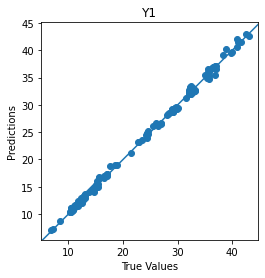

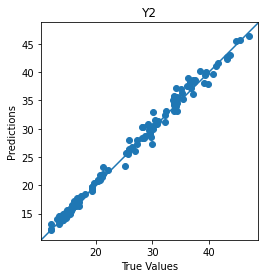

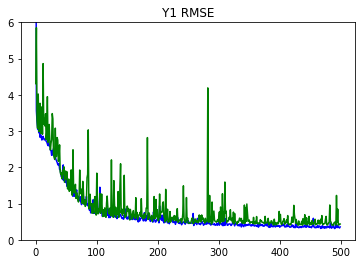

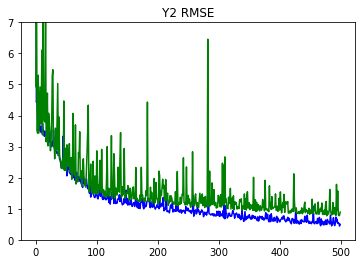

In [9]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)